In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from numpy import split, array
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D
from sklearn.model_selection import GridSearchCV


In [ ]:
import pandas as pd

# Load the dataset
path = '/content/drive/MyDrive/Data_Science/01_Projects/04_Pakistan_Energy_Demand/Data/pak_load_till_2023_output.csv'
dataset = pd.read_csv(path)

# Convert the 'datetime' columns to a single datetime column
dataset['datetime'] = pd.to_datetime(dataset[['YEAR', 'MONTH', 'DAY', 'Hour']])

# Set 'datetime' as the index
dataset.set_index('datetime', inplace=True)

# Drop unnecessary columns
dataset.drop(['YEAR', 'MONTH', 'DAY', 'Hour'], axis=1, inplace=True)

# Extract additional date-related features
dataset['year'] = dataset.index.year
dataset['month'] = dataset.index.month
dataset['dayofweek'] = dataset.index.dayofweek
dataset['hour'] = dataset.index.hour

# Display the first row of the modified dataset
print(dataset.head(1))
print(dataset.tail(2))


                         Demand  year  month  dayofweek  hour
datetime                                                     
2019-07-01 01:00:00  19615.2656  2019      7          0     1
                          Demand  year  month  dayofweek  hour
datetime                                                      
2023-12-31 23:00:00  9985.278435  2023     12          6    23
2024-01-01 00:00:00  9002.855797  2024      1          0     0


In [ ]:
dataset.head()
# Assuming you have a DataFrame df with your dataset
dataset = dataset[['year', 'month', 'dayofweek', 'hour', 'Demand']]
dataset.head(1)


,year,month,dayofweek,hour,Demand
datetime,,,,,
2019-07-01 01:00:00,2019,7,0,1,19615.2656


In [ ]:
data = dataset

In [ ]:

from matplotlib import style
fig = plt.figure()
axes1 = plt.subplot2grid((1,1), (0,0))

style.use("ggplot")
sns.lineplot(x= dataset["Year"], y= dataset["Demand"], data = dataset)
sns.set(rc={'figure.figsize': (30,30)})

plt.title("Electricity consumption 1")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in axes1.xaxis.get_ticklabels():
    label.set_rotation(90)

In [ ]:
# Resample the dataset at a daily frequency and calculate the mean
newDataSet = data.resample("D").mean()
# Omit one row at the end of the resampled dataset
# 1646 -1 =1645/7 235 weeks
# 235 * 80 = 188 for train
# 235 - 188 = 47 for test
newDataSet = newDataSet.iloc[:-1]
# Display the first few rows of the resampled dataset
print(newDataSet.head())
print(newDataSet.shape)

              year  month  dayofweek  hour        Demand
datetime                                                
2019-07-01  2019.0    7.0        0.0  12.0  19309.086209
2019-07-02  2019.0    7.0        1.0  11.5  19667.606325
2019-07-03  2019.0    7.0        2.0  11.5  20422.855358
2019-07-04  2019.0    7.0        3.0  11.5  19702.835742
2019-07-05  2019.0    7.0        4.0  11.5  18838.397733
(1645, 5)


In [ ]:
y = newDataSet["Demand"]
print(y[0])
y.shape

19309.08620869565


(1645,)

In [ ]:
# Normalize data before model fitting
# it will boost the performance( in neural networks) + transform
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1))
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")
print(y[:10])

Normalizing data before model fitting
[[0.91806392]
 [0.94443899]
 [1.        ]
 [0.94703069]
 [0.88343703]
 [0.81160418]
 [0.89298101]
 [0.98384646]
 [0.9446605 ]
 [0.95068641]]


In [ ]:
training_size = int(len(y)*0.80)
test_size = len(y)- training_size
val_size = int(training_size*0.20)
train_data , test_data , val_data = y[0:training_size-val_size,:] , y[training_size:len(y),:1], y[len(y)-test_size-val_size:len(y)-test_size,:1]


In [ ]:
# building input variable
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)


In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [ ]:

# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (952, 100, 1)
X_test shape:  (228, 100, 1)
X_val shape:  (162, 100, 1)


In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 4)
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(dropout_rate))

    for _ in range(n_lstm_layers - 1):
        model.add(LSTM(units=lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')



    history = model.fit(X_train, y_train, validation_data=(X_val, yval), epochs=trial.suggest_int('epochs', 10, 50), batch_size=trial.suggest_int('batch_size', 16, 64), verbose=2)

    val_loss = model.evaluate(X_val, yval, verbose=0)
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize hyperparameters
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

# Build the final model with the best hyperparameters
best_model = Sequential()
best_model.add(LSTM(units=best_params['lstm_units'], return_sequences=True, input_shape=(time_step, 1)))
best_model.add(Dropout(best_params['dropout_rate']))

for _ in range(best_params['n_lstm_layers'] - 1):
    best_model.add(LSTM(units=best_params['lstm_units'], return_sequences=True))
    best_model.add(Dropout(best_params['dropout_rate']))

best_model.add(LSTM(units=best_params['lstm_units']))
best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(units=1))

optimizer = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=optimizer, loss='mean_squared_error')



[I 2023-10-17 11:53:33,834] A new study created in memory with name: no-name-79f4c1d6-6015-4aec-9ee3-697d20a83776
<ipython-input-16-483fdd64cc9d>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
<ipython-input-16-483fdd64cc9d>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/13
19/19 - 34s - loss: 0.0395 - val_loss: 0.0042 - 34s/epoch - 2s/step
Epoch 2/13
19/19 - 7s - loss: 0.0060 - val_loss: 0.0031 - 7s/epoch - 346ms/step
Epoch 3/13
19/19 - 10s - loss: 0.0038 - val_loss: 0.0033 - 10s/epoch - 508ms/step
Epoch 4/13
19/19 - 6s - loss: 0.0034 - val_loss: 0.0019 - 6s/epoch - 298ms/step
Epoch 5/13
19/19 - 6s - loss: 0.0032 - val_loss: 0.0028 - 6s/epoch - 311ms/step
Epoch 6/13
19/19 - 9s - loss: 0.0031 - val_loss: 0.0014 - 9s/epoch - 494ms/step
Epoch 7/13
19/19 - 5s - loss: 0.0029 - val_loss: 0.0014 - 5s/epoch - 283ms/step
Epoch 8/13
19/19 - 8s - loss: 0.0028 - val_loss: 0.0015 - 8s/epoch - 395ms/step
Epoch 9/13
19/19 - 8s - loss: 0.0027 - val_loss: 0.0017 - 8s/epoch - 415ms/step
Epoch 10/13
19/19 - 5s - loss: 0.0026 - val_loss: 0.0011 - 5s/epoch - 281ms/step
Epoch 11/13
19/19 - 10s - loss: 0.0027 - val_loss: 0.0011 - 10s/epoch - 513ms/step
Epoch 12/13
19/19 - 6s - loss: 0.0026 - val_loss: 0.0010 - 6s/epoch - 332ms/step
Epoch 13/13
19/19 - 6s - loss: 0.0

[I 2023-10-17 11:56:14,767] Trial 0 finished with value: 0.0010407972149550915 and parameters: {'n_lstm_layers': 1, 'lstm_units': 98, 'dropout_rate': 0.008781052579394377, 'learning_rate': 0.0008352017938744266, 'epochs': 13, 'batch_size': 51}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/30
19/19 - 29s - loss: 0.1417 - val_loss: 0.0088 - 29s/epoch - 2s/step
Epoch 2/30
19/19 - 19s - loss: 0.0213 - val_loss: 0.0072 - 19s/epoch - 978ms/step
Epoch 3/30
19/19 - 18s - loss: 0.0167 - val_loss: 0.0125 - 18s/epoch - 968ms/step
Epoch 4/30
19/19 - 18s - loss: 0.0133 - val_loss: 0.0088 - 18s/epoch - 962ms/step
Epoch 5/30
19/19 - 18s - loss: 0.0122 - val_loss: 0.0080 - 18s/epoch - 927ms/step
Epoch 6/30
19/19 - 19s - loss: 0.0113 - val_loss: 0.0091 - 19s/epoch - 983ms/step
Epoch 7/30
19/19 - 18s - loss: 0.0113 - val_loss: 0.0092 - 18s/epoch - 960ms/step
Epoch 8/30
19/19 - 18s - loss: 0.0105 - val_loss: 0.0053 - 18s/epoch - 952ms/step
Epoch 9/30
19/19 - 18s - loss: 0.0093 - val_loss: 0.0048 - 18s/epoch - 958ms/step
Epoch 10/30
19/19 - 18s - loss: 0.0092 - val_loss: 0.0050 - 18s/epoch - 964ms/step
Epoch 11/30
19/19 - 18s - loss: 0.0080 - val_loss: 0.0037 - 18s/epoch - 955ms/step
Epoch 12/30
19/19 - 18s - loss: 0.0071 - val_loss: 0.0025 - 18s/epoch - 961ms/step
Epoch 13/30
19/1

[I 2023-10-17 12:05:38,702] Trial 1 finished with value: 0.0019872381817549467 and parameters: {'n_lstm_layers': 3, 'lstm_units': 114, 'dropout_rate': 0.2596581838239443, 'learning_rate': 8.622681459047484e-05, 'epochs': 30, 'batch_size': 52}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/18
18/18 - 20s - loss: 0.0648 - val_loss: 0.0166 - 20s/epoch - 1s/step
Epoch 2/18
18/18 - 9s - loss: 0.0173 - val_loss: 0.0083 - 9s/epoch - 503ms/step
Epoch 3/18
18/18 - 9s - loss: 0.0104 - val_loss: 0.0066 - 9s/epoch - 486ms/step
Epoch 4/18
18/18 - 10s - loss: 0.0085 - val_loss: 0.0042 - 10s/epoch - 537ms/step
Epoch 5/18
18/18 - 8s - loss: 0.0077 - val_loss: 0.0045 - 8s/epoch - 472ms/step
Epoch 6/18
18/18 - 10s - loss: 0.0067 - val_loss: 0.0023 - 10s/epoch - 553ms/step
Epoch 7/18
18/18 - 8s - loss: 0.0060 - val_loss: 0.0028 - 8s/epoch - 435ms/step
Epoch 8/18
18/18 - 10s - loss: 0.0057 - val_loss: 0.0048 - 10s/epoch - 581ms/step
Epoch 9/18
18/18 - 8s - loss: 0.0061 - val_loss: 0.0034 - 8s/epoch - 423ms/step
Epoch 10/18
18/18 - 11s - loss: 0.0053 - val_loss: 0.0020 - 11s/epoch - 601ms/step
Epoch 11/18
18/18 - 8s - loss: 0.0058 - val_loss: 0.0025 - 8s/epoch - 423ms/step
Epoch 12/18
18/18 - 11s - loss: 0.0058 - val_loss: 0.0020 - 11s/epoch - 616ms/step
Epoch 13/18
18/18 - 7s - los

[I 2023-10-17 12:09:11,439] Trial 2 finished with value: 0.002921840874478221 and parameters: {'n_lstm_layers': 3, 'lstm_units': 84, 'dropout_rate': 0.11408649995760994, 'learning_rate': 0.0003516421712851631, 'epochs': 18, 'batch_size': 53}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/39
28/28 - 15s - loss: 0.0586 - val_loss: 0.0070 - 15s/epoch - 542ms/step
Epoch 2/39
28/28 - 5s - loss: 0.0114 - val_loss: 0.0093 - 5s/epoch - 187ms/step
Epoch 3/39
28/28 - 6s - loss: 0.0082 - val_loss: 0.0037 - 6s/epoch - 214ms/step
Epoch 4/39
28/28 - 8s - loss: 0.0076 - val_loss: 0.0024 - 8s/epoch - 285ms/step
Epoch 5/39
28/28 - 5s - loss: 0.0062 - val_loss: 0.0027 - 5s/epoch - 183ms/step
Epoch 6/39
28/28 - 6s - loss: 0.0065 - val_loss: 0.0079 - 6s/epoch - 224ms/step
Epoch 7/39
28/28 - 8s - loss: 0.0064 - val_loss: 0.0031 - 8s/epoch - 282ms/step
Epoch 8/39
28/28 - 5s - loss: 0.0057 - val_loss: 0.0016 - 5s/epoch - 181ms/step
Epoch 9/39
28/28 - 7s - loss: 0.0055 - val_loss: 0.0016 - 7s/epoch - 233ms/step
Epoch 10/39
28/28 - 8s - loss: 0.0052 - val_loss: 0.0021 - 8s/epoch - 274ms/step
Epoch 11/39
28/28 - 5s - loss: 0.0059 - val_loss: 0.0015 - 5s/epoch - 180ms/step
Epoch 12/39
28/28 - 7s - loss: 0.0050 - val_loss: 0.0023 - 7s/epoch - 246ms/step
Epoch 13/39
28/28 - 7s - loss: 0.00

[I 2023-10-17 12:13:39,169] Trial 3 finished with value: 0.0012919945875182748 and parameters: {'n_lstm_layers': 2, 'lstm_units': 57, 'dropout_rate': 0.1767193085794715, 'learning_rate': 0.0005465248798965377, 'epochs': 39, 'batch_size': 35}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/24
34/34 - 23s - loss: 0.0447 - val_loss: 0.0274 - 23s/epoch - 685ms/step
Epoch 2/24
34/34 - 13s - loss: 0.0161 - val_loss: 0.0064 - 13s/epoch - 386ms/step
Epoch 3/24
34/34 - 13s - loss: 0.0111 - val_loss: 0.0084 - 13s/epoch - 387ms/step
Epoch 4/24
34/34 - 10s - loss: 0.0108 - val_loss: 0.0046 - 10s/epoch - 304ms/step
Epoch 5/24
34/34 - 13s - loss: 0.0098 - val_loss: 0.0031 - 13s/epoch - 391ms/step
Epoch 6/24
34/34 - 12s - loss: 0.0104 - val_loss: 0.0024 - 12s/epoch - 353ms/step
Epoch 7/24
34/34 - 11s - loss: 0.0092 - val_loss: 0.0036 - 11s/epoch - 329ms/step
Epoch 8/24
34/34 - 14s - loss: 0.0090 - val_loss: 0.0023 - 14s/epoch - 401ms/step
Epoch 9/24
34/34 - 12s - loss: 0.0076 - val_loss: 0.0040 - 12s/epoch - 348ms/step
Epoch 10/24
34/34 - 12s - loss: 0.0085 - val_loss: 0.0064 - 12s/epoch - 343ms/step
Epoch 11/24
34/34 - 13s - loss: 0.0089 - val_loss: 0.0030 - 13s/epoch - 394ms/step
Epoch 12/24
34/34 - 11s - loss: 0.0077 - val_loss: 0.0050 - 11s/epoch - 335ms/step
Epoch 13/24
3

[I 2023-10-17 12:19:11,399] Trial 4 finished with value: 0.0024987722281366587 and parameters: {'n_lstm_layers': 4, 'lstm_units': 65, 'dropout_rate': 0.3371915173873752, 'learning_rate': 0.0006593395013393289, 'epochs': 24, 'batch_size': 28}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/50
27/27 - 22s - loss: 0.2174 - val_loss: 0.1629 - 22s/epoch - 827ms/step
Epoch 2/50
27/27 - 14s - loss: 0.1613 - val_loss: 0.1000 - 14s/epoch - 518ms/step
Epoch 3/50
27/27 - 13s - loss: 0.0908 - val_loss: 0.0286 - 13s/epoch - 478ms/step
Epoch 4/50
27/27 - 12s - loss: 0.0286 - val_loss: 0.0118 - 12s/epoch - 426ms/step
Epoch 5/50
27/27 - 14s - loss: 0.0189 - val_loss: 0.0110 - 14s/epoch - 521ms/step
Epoch 6/50
27/27 - 14s - loss: 0.0172 - val_loss: 0.0095 - 14s/epoch - 510ms/step
Epoch 7/50
27/27 - 11s - loss: 0.0184 - val_loss: 0.0111 - 11s/epoch - 398ms/step
Epoch 8/50
27/27 - 14s - loss: 0.0182 - val_loss: 0.0092 - 14s/epoch - 528ms/step
Epoch 9/50
27/27 - 14s - loss: 0.0173 - val_loss: 0.0104 - 14s/epoch - 523ms/step
Epoch 10/50
27/27 - 11s - loss: 0.0177 - val_loss: 0.0083 - 11s/epoch - 397ms/step
Epoch 11/50
27/27 - 14s - loss: 0.0163 - val_loss: 0.0095 - 14s/epoch - 505ms/step
Epoch 12/50
27/27 - 14s - loss: 0.0162 - val_loss: 0.0085 - 14s/epoch - 522ms/step
Epoch 13/50
2

[I 2023-10-17 12:30:41,450] Trial 5 finished with value: 0.0021888127084821463 and parameters: {'n_lstm_layers': 3, 'lstm_units': 82, 'dropout_rate': 0.3806303654216151, 'learning_rate': 2.2334381648187777e-05, 'epochs': 50, 'batch_size': 36}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/27
18/18 - 21s - loss: 0.2882 - val_loss: 0.2448 - 21s/epoch - 1s/step
Epoch 2/27
18/18 - 14s - loss: 0.2543 - val_loss: 0.2123 - 14s/epoch - 785ms/step
Epoch 3/27
18/18 - 14s - loss: 0.2228 - val_loss: 0.1813 - 14s/epoch - 784ms/step
Epoch 4/27
18/18 - 12s - loss: 0.1921 - val_loss: 0.1503 - 12s/epoch - 648ms/step
Epoch 5/27
18/18 - 13s - loss: 0.1601 - val_loss: 0.1172 - 13s/epoch - 702ms/step
Epoch 6/27
18/18 - 14s - loss: 0.1247 - val_loss: 0.0821 - 14s/epoch - 781ms/step
Epoch 7/27
18/18 - 14s - loss: 0.0890 - val_loss: 0.0472 - 14s/epoch - 764ms/step
Epoch 8/27
18/18 - 10s - loss: 0.0539 - val_loss: 0.0183 - 10s/epoch - 572ms/step
Epoch 9/27
18/18 - 14s - loss: 0.0260 - val_loss: 0.0064 - 14s/epoch - 784ms/step
Epoch 10/27
18/18 - 14s - loss: 0.0135 - val_loss: 0.0094 - 14s/epoch - 783ms/step
Epoch 11/27
18/18 - 12s - loss: 0.0132 - val_loss: 0.0104 - 12s/epoch - 690ms/step
Epoch 12/27
18/18 - 12s - loss: 0.0124 - val_loss: 0.0088 - 12s/epoch - 655ms/step
Epoch 13/27
18/1

[I 2023-10-17 12:36:47,236] Trial 6 finished with value: 0.007370999548584223 and parameters: {'n_lstm_layers': 2, 'lstm_units': 115, 'dropout_rate': 0.19252858957639024, 'learning_rate': 1.3564714717031144e-05, 'epochs': 27, 'batch_size': 55}. Best is trial 0 with value: 0.0010407972149550915.


Epoch 1/20
17/17 - 26s - loss: 0.0951 - val_loss: 0.0296 - 26s/epoch - 2s/step
Epoch 2/20
17/17 - 9s - loss: 0.0241 - val_loss: 0.0092 - 9s/epoch - 513ms/step
Epoch 3/20
17/17 - 12s - loss: 0.0106 - val_loss: 0.0050 - 12s/epoch - 703ms/step
Epoch 4/20
17/17 - 10s - loss: 0.0083 - val_loss: 0.0031 - 10s/epoch - 585ms/step
Epoch 5/20
17/17 - 11s - loss: 0.0085 - val_loss: 0.0049 - 11s/epoch - 633ms/step
Epoch 6/20
17/17 - 12s - loss: 0.0086 - val_loss: 0.0040 - 12s/epoch - 708ms/step
Epoch 7/20
17/17 - 9s - loss: 0.0072 - val_loss: 0.0050 - 9s/epoch - 516ms/step
Epoch 8/20
17/17 - 12s - loss: 0.0081 - val_loss: 0.0047 - 12s/epoch - 707ms/step
Epoch 9/20
17/17 - 10s - loss: 0.0070 - val_loss: 0.0023 - 10s/epoch - 586ms/step
Epoch 10/20
17/17 - 11s - loss: 0.0069 - val_loss: 0.0024 - 11s/epoch - 636ms/step
Epoch 11/20
17/17 - 12s - loss: 0.0065 - val_loss: 0.0016 - 12s/epoch - 697ms/step
Epoch 12/20


In [ ]:

best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_7 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_41 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_42 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_43 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 7105

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)


Epoch 1/60
48/48 [==============================] - 10s 45ms/step - loss: 0.0226 - val_loss: 0.0089
Epoch 2/60
48/48 [==============================] - 1s 17ms/step - loss: 0.0056 - val_loss: 0.0086
Epoch 3/60
48/48 [==============================] - 1s 17ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 4/60
48/48 [==============================] - 1s 17ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 5/60
48/48 [==============================] - 1s 17ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 6/60
48/48 [==============================] - 1s 17ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 7/60
48/48 [==============================] - 1s 19ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 8/60
48/48 [==============================] - 1s 25ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/60
48/48 [==============================] - 1s 24ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 10/60
48/48 [==============================] - 2s 36ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 11

In [ ]:
model.save('/content/drive/MyDrive/Data_Science/01_Projects/04_Pakistan_Energy_Demand/Trained_models/Stacked_LSTM')

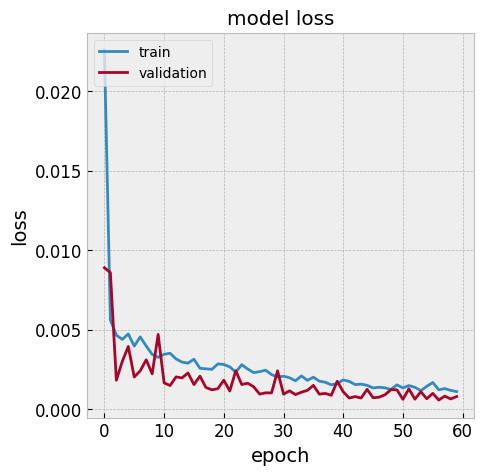

In [ ]:

plt.figure(figsize=(5,5))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
import tensorflow as tf
tf.__version__


'2.13.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)

6/6 [==============================] - 0s 9ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)


In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

13411.719878198704

In [ ]:

print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)

(952, 1)
(228, 1)
(162, 1)
[12503.086]
(952,)


30/30 [==============================] - 0s 12ms/step
   Train Predictions       Actuals
0       12503.085938  12745.291667
1       12744.941406  13085.636875
2       13023.763672  12963.596458
3       13026.465820  13306.939167
4       13013.056641  13335.713517
5       12947.005859  13532.514442
6       12936.938477  13697.518875
7       12986.812500  13671.797600
8       12989.228516  13051.270142
9       12681.112305  10742.702592


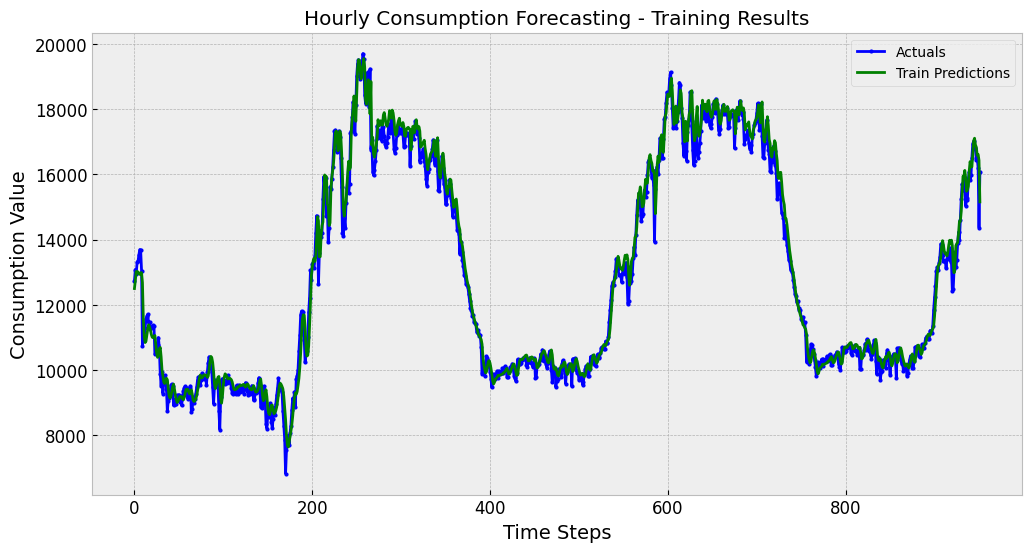

In [ ]:
import matplotlib.pyplot as plt

# Predict consumption using training data
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)

# Create NumPy arrays for train predictions and actual values
train_predictions_array = train_predictions.flatten()
actual_array = actual.flatten()

# Create a DataFrame for easier plotting
train_results = pd.DataFrame({'Train Predictions': train_predictions_array, 'Actuals': actual_array})
print(train_results.head(10))

# Plot the training results
plt.figure(figsize=(12, 6))
plt.plot(train_results.index, train_results['Actuals'], label='Actuals', color='blue', marker='o', markersize=2)
plt.plot(train_results.index, train_results['Train Predictions'], label='Train Predictions', color='green', markersize=2)

plt.xlabel('Time Steps')
plt.ylabel('Consumption Value')
plt.title('Hourly Consumption Forecasting - Training Results')
plt.legend()
plt.grid(True)
plt.show()


6/6 [==============================] - 0s 13ms/step


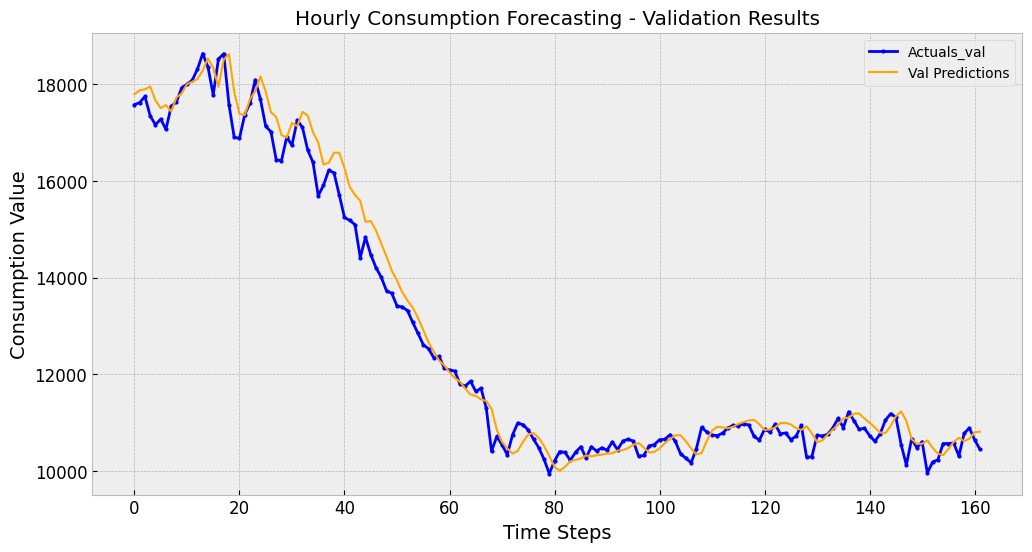

In [ ]:
import matplotlib.pyplot as plt

# Predict consumption using validation data
val_predictions = model.predict(X_val)
val_predictions = scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

# Create NumPy arrays for validation predictions and actual values
val_predictions_array = val_predictions.flatten()
actual_val_array = actual_val.flatten()

# Create a DataFrame for easier plotting
val_results = pd.DataFrame({'Val Predictions': val_predictions_array, 'Actuals_val': actual_val_array})

# Plot the validation results
plt.figure(figsize=(12, 6))
plt.plot(val_results.index, val_results['Actuals_val'], label='Actuals_val', color='blue', marker='o', markersize=2)
plt.plot(val_results.index, val_results['Val Predictions'], label='Val Predictions', color='orange', linewidth=1.5)  # Orange and solid

plt.xlabel('Time Steps')
plt.ylabel('Consumption Value')
plt.title('Hourly Consumption Forecasting - Validation Results')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 0s 13ms/step


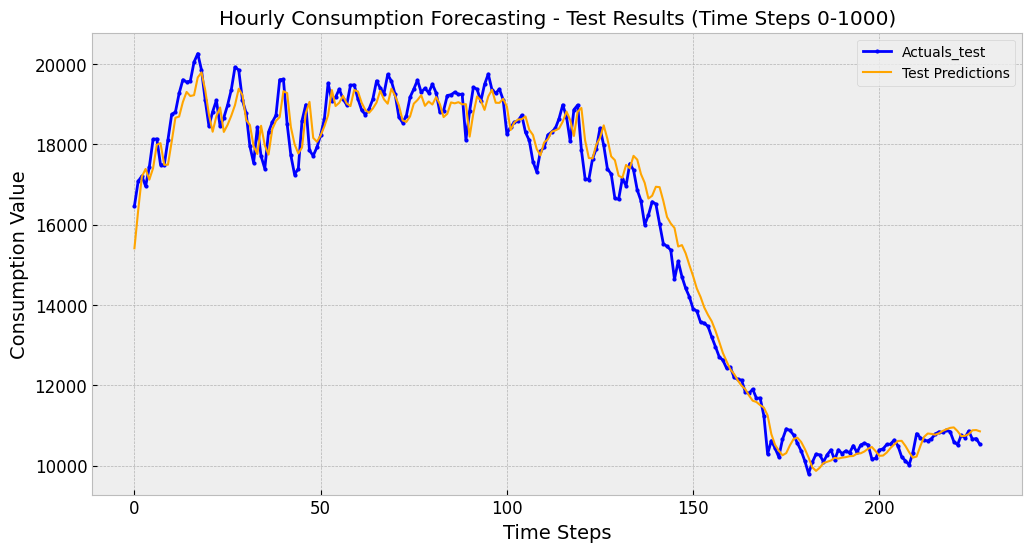

In [ ]:
import matplotlib.pyplot as plt

# Predict consumption using test data
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

# Create NumPy arrays for test predictions and actual values
test_predictions_array = test_predictions.flatten()
actual_test_array = actual_test.flatten()

# Create a DataFrame for easier plotting
test_results = pd.DataFrame({'Test Predictions': test_predictions_array, 'Actuals_test': actual_test_array})

# Plot the test results for a specific range of time steps (e.g., start_time and end_time)
start_time = 0  # Adjust the start time step as needed
end_time = 1000  # Adjust the end time step as needed

plt.figure(figsize=(12, 6))
plt.plot(test_results.index[start_time:end_time], test_results['Actuals_test'].iloc[start_time:end_time], label='Actuals_test', color='blue', marker='o', markersize=2)
plt.plot(test_results.index[start_time:end_time], test_results['Test Predictions'].iloc[start_time:end_time], label='Test Predictions', color='orange', linewidth=1.5)  # Orange and solid

plt.xlabel('Time Steps')
plt.ylabel('Consumption Value')
plt.title('Hourly Consumption Forecasting - Test Results (Time Steps {}-{})'.format(start_time, end_time))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Define the length of your data
data_len = len(y)
look_back=100

# Create arrays for plotting
trainPredictPlot = np.empty((data_len, 1))
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : look_back + len(train_predictions), :] = train_predictions

testPredictPlot = np.empty((data_len, 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back + len(train_predictions) + 1 : look_back + len(train_predictions) + 1 + len(test_predictions), :] = test_predictions

# Plot baseline and predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(y), color='blue')  # Actual Consumption (blue)
plt.plot(trainPredictPlot, color='green')  # Train Predictions (green)
plt.plot(testPredictPlot, color='red')  # Test Predictions (red)
plt.legend(['Actual Consumption', 'Train Predictions', 'Test Predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()